<a href="https://colab.research.google.com/github/ghanbarzadeh/Death-Wallpaper/blob/main/ANN_project/OD_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Helper functions

In [19]:
# Helper function for saving figures
def save_fig(name):
    # plt.gca().set_axis_off()
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                hspace = 0, wspace = 0.15)
    plt.margins(0,0)
    # plt.gca().xaxis.set_major_locator(plt.NullLocator())
    # plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.savefig((name+'.pdf'), bbox_inches = 'tight',
        pad_inches = 0)

In [20]:
# Helper function for saving figures
def save_bar(name):
    # plt.gca().set_axis_off()
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                hspace = 0, wspace = 0)
    plt.margins(0.05,0.3)
    # plt.gca().xaxis.set_major_locator(plt.NullLocator())
    # plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.savefig((name+'.pdf'), bbox_inches = 'tight',
        pad_inches = 0)

In [51]:
# Helper function for saving figures
def save_img(name):
    plt.gca().set_axis_off()
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                hspace = 0, wspace = 0)
    plt.margins(0,0)
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.savefig((name+'.pdf'), bbox_inches = 'tight',
        pad_inches = 0)

# Installing prerequisites

In [ ]:
!pip install -U --pre tensorflow-gpu=="2.3.0"

In [ ]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

In [ ]:
%cd models/research/
!protoc object_detection/protos/*.proto --python_out=.
!cp object_detection/packages/tf2/setup.py .
!python -m pip install .

# Run Inference on Test Images with ground truth data

In [93]:
import matplotlib
import matplotlib.pyplot as plt

import os
import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

%matplotlib inline

import json
import os
import glob
import pandas as pd
import argparse
import xml.etree.ElementTree as ET

In [94]:
#map labels for inference decoding
label_map_path = '/content/drive/MyDrive/Armin/mask_dataset/object_detection_dataset/label_map.pbtxt'
label_map = label_map_util.load_labelmap(label_map_path)
categories = label_map_util.convert_label_map_to_categories(
    label_map,
    max_num_classes=label_map_util.get_max_label_map_index(label_map),
    use_display_name=True)
category_index = label_map_util.create_category_index(categories)
label_map_dict = label_map_util.get_label_map_dict(label_map, use_display_name=True)

In [95]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: the file path to the image

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [ ]:
import pathlib

filenames = list(pathlib.Path('/content/drive/MyDrive/Armin/mask_dataset/object_detection_weights/').glob('*.index'))
pipeline_file = '/content/drive/MyDrive/Armin/mask_dataset/object_detection_model/pipeline.config'

filenames.sort()
print(filenames)

#recover our saved model
pipeline_config = pipeline_file
#generally you want to put the last ckpt from training in here
model_dir = str(filenames[-1]).replace('.index','')
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
detection_model = model_builder.build(
      model_config=model_config, is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(
      model=detection_model)
ckpt.restore(os.path.join(str(filenames[-1]).replace('.index','')))


def get_model_detection_function(model):
  """Get a tf.function for detection."""

  @tf.function
  def detect_fn(image):
    """Detect objects in image."""

    image, shapes = model.preprocess(image)
    prediction_dict = model.predict(image, shapes)
    detections = model.postprocess(prediction_dict, shapes)

    return detections, prediction_dict, tf.reshape(shapes, [-1])

  return detect_fn

detect_fn = get_model_detection_function(detection_model)

In [ ]:
image_paths = ['/content/drive/MyDrive/Armin/mask_dataset/converted_to_jpg/images/maksssksksss809.jpg', 
               '/content/drive/MyDrive/Armin/mask_dataset/converted_to_jpg/images/maksssksksss741.jpg', 
               '/content/drive/MyDrive/Armin/mask_dataset/converted_to_jpg/images/maksssksksss475.jpg', 
               '/content/drive/MyDrive/Armin/mask_dataset/converted_to_jpg/images/maksssksksss760.jpg',
               '/content/drive/MyDrive/Armin/mask_dataset/converted_to_jpg/images/maksssksksss496.jpg']

c = 0
for image_path in image_paths:
    image_np = load_image_into_numpy_array(image_path)
    input_tensor = tf.convert_to_tensor(
        np.expand_dims(image_np, 0), dtype=tf.float32)
    
    # detections, predictions_dict, shapes = detect_fn(input_tensor)

    # print(detections['detection_boxes'][0].numpy())
    label_id_offset = 1
    image_np_with_detections = image_np.copy()
    xml_file = os.path.join('/content/drive/MyDrive/Armin/mask_dataset/original/annotations', image_path.split('/')[-1].split('.')[0] + '.xml')
    tree = ET.parse(xml_file)
    root = tree.getroot()
    boxes = []
    classes = []
    for member in root.findall('object'):
        boxes.append([float(member[5][1].text)/int(root.find('size')[1].text), 
                        float(member[5][0].text)/int(root.find('size')[0].text), 
                        float(member[5][3].text)/int(root.find('size')[1].text), 
                        float(member[5][2].text)/int(root.find('size')[0].text)])
        if member[0].text == 'mask_weared_incorrect':
            classes.append(0)
        elif member[0].text == 'with_mask':
            classes.append(1)
        else:
            classes.append(2)
    classes = np.array(classes)
    boxes = np.array(boxes)
    

    viz_utils.visualize_boxes_and_labels_on_image_array(
          image_np_with_detections,
          boxes,
          (classes + label_id_offset).astype(int),
          np.ones(classes.shape),
          category_index,
          use_normalized_coordinates=True,
          max_boxes_to_draw=200,
          min_score_thresh=.4,
          agnostic_mode=False,
          skip_scores=True,
    )
    plt.clf()
    plt.close()
    plt.figure(figsize=(10, 15))
    plt.imshow(image_np_with_detections)
    plt.axis('off')
    plt.savefig((str(c+10)+'.pdf'), bbox_inches = 'tight',
        pad_inches = 0)
    plt.show()
    c = c + 1

In [ ]:
for image_path in image_paths:
    image_np = load_image_into_numpy_array(image_path)
    input_tensor = tf.convert_to_tensor(
        np.expand_dims(image_np, 0), dtype=tf.float32)
    detections, predictions_dict, shapes = detect_fn(input_tensor)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_detections,
        detections['detection_boxes'][0].numpy(),
        (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
        detections['detection_scores'][0].numpy(),
        category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=200,
        min_score_thresh=.4,
        agnostic_mode=False,
        skip_scores=False,
    )

    plt.figure(figsize=(10, 15))
    plt.imshow(image_np_with_detections)
    plt.axis('off')
    plt.savefig((str(c+10)+'.pdf'), bbox_inches = 'tight',
        pad_inches = 0)
    plt.show()
    c = c + 1

In [ ]:
%load_ext tensorboard
%tensorboard --logdir '/content/drive/MyDrive/Armin/mask_dataset/object_detection_weights/train'

# Webcam test

In [90]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


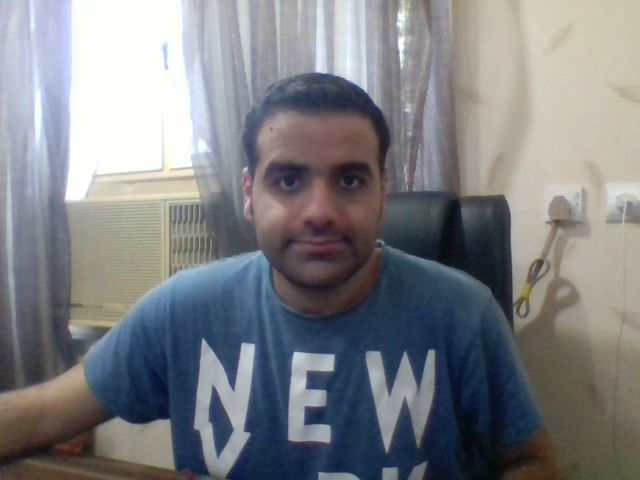

In [115]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

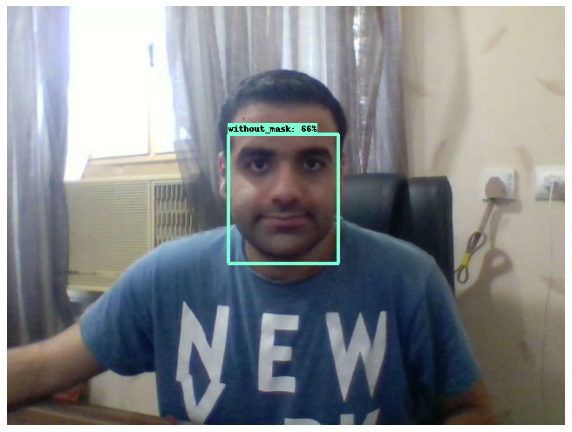

In [116]:
import matplotlib
import matplotlib.pyplot as plt

import os
import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

%matplotlib inline

import json
import os
import glob
import pandas as pd
import argparse
import xml.etree.ElementTree as ET

image_path = '/content/models/research/photo.jpg'
image_np = load_image_into_numpy_array(image_path)
input_tensor = tf.convert_to_tensor(
    np.expand_dims(image_np, 0), dtype=tf.float32)
detections, predictions_dict, shapes = detect_fn(input_tensor)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
    image_np_with_detections,
    detections['detection_boxes'][0].numpy(),
    (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
    detections['detection_scores'][0].numpy(),
    category_index,
    use_normalized_coordinates=True,
    max_boxes_to_draw=200,
    min_score_thresh=.55,
    agnostic_mode=False,
    skip_scores=False,
)

plt.figure(figsize=(10, 15))
plt.imshow(image_np_with_detections)
plt.axis('off')
plt.savefig(('testinc'+'.png'), bbox_inches = 'tight',
        pad_inches = 0)
plt.show()

# Animation